<a href="https://colab.research.google.com/github/CaptainAtharva/CNN-projects/blob/main/Pneumonia_Detection_with_AlexNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install kaggle

In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/My Drive/kaggle'

In [2]:
%cd /content/drive/My Drive/kaggle

/content/drive/My Drive/kaggle


In [79]:
#!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

User cancelled operation


In [12]:
#!unzip \*.zip && rm*.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [3]:
import cv2

labels = ['PNEUMONIA','NORMAL']
img_size = 224


def get_training_data(data_dir):
  data=[]
  for label in labels:
    path = os.path.join(data_dir,label) # goes to the PNEUMONIA / NORMAL folder
    class_num = labels.index(label)  # labels PNEUMONIA as 0, NORMAL as 1

    for img in os.listdir(path): #iterating over each image in the folder
      try:
        img_arr = cv2.imread(os.path.join(path,img),cv2.IMREAD_GRAYSCALE) #getting the grayscale img array
        resize_arr = cv2.resize(img_arr, (img_size,img_size)) #resizing the arrray to 150x150

        data.append([resize_arr, class_num]) #data is a 2d array of img_array and corresponding label

      except Exception as e:
        print(e)


  return np.array(data)



In [4]:
import numpy as np

**LOADING THE DATASET**

In [5]:
train = get_training_data('/content/drive/MyDrive/kaggle/chest_xray/train')
test = get_training_data('/content/drive/MyDrive/kaggle/chest_xray/test')
val = get_training_data('/content/drive/MyDrive/kaggle/chest_xray/val')

<ipython-input-3-e96a69c55492>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


In [6]:
print('Train shape',train.shape) #(5216 ,2) --> 5216 training examples and 2 categories (PNEUMONIA/ NORMAL)
print('Test shape',test.shape)
print('Val shape',val.shape)

Train shape (5216, 2)
Test shape (624, 2)
Val shape (16, 2)


**VISUALIZING THE DATA**

In [7]:
print(train[4][0].shape) # shows the pixel values of the 4th training image
print(train[4][1]) # shows the class of the 4th training image --> PNEUMONIA

(224, 224)
0


Text(0.5, 1.0, 'Training samples')

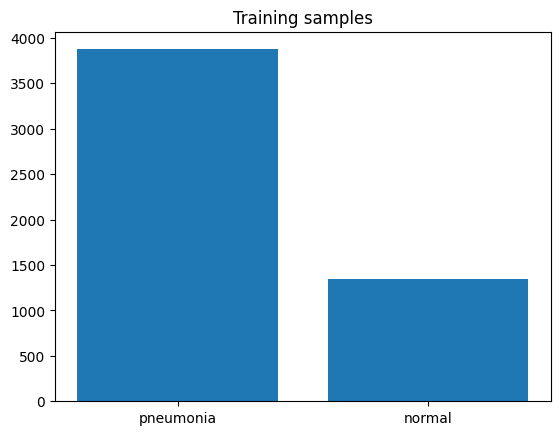

In [8]:
l = {'pneumonia':0 , 'normal':0}

for i in train:
  if(i[1] == 0):
    l['pneumonia'] += 1
  else:
    l['normal'] +=1

import matplotlib.pyplot as plt
plt.bar(l.keys(),l.values())
plt.title('Training samples')


In [30]:
## Image augmentation can be used for the 'normal' images to increse training samples

Text(0.5, 1.0, 'NORMAL')

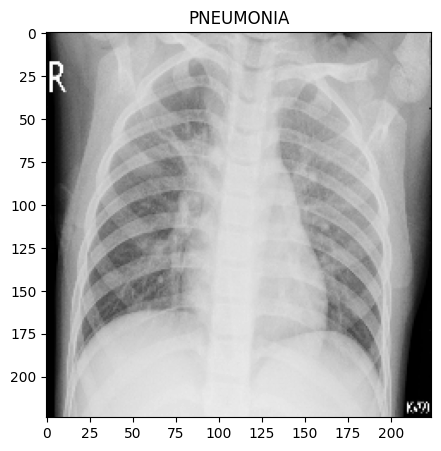

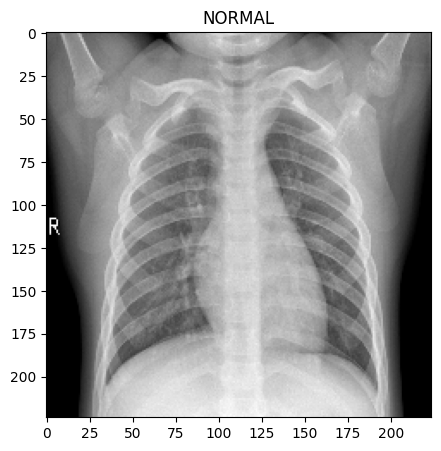

In [9]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

**Now Splitting into x and y in train,test,val**

In [10]:
x_train=[]
y_train=[]

x_test=[]
y_test=[]

x_val=[]
y_val=[]

for features, labels in train:
  x_train.append(features)
  y_train.append(labels)

for features, labels in test:
  x_test.append(features)
  y_test.append(labels)

for features, labels in val:
  x_val.append(features)
  y_val.append(labels)

In [11]:
x_train[10]

array([[100,  96, 106, ..., 137, 127, 123],
       [104, 109, 103, ..., 138, 135, 122],
       [ 95, 102, 104, ..., 135, 124, 126],
       ...,
       [  7,  32,  58, ...,  54,  64,  64],
       [  7,  35,  58, ...,  41,  42,  45],
       [  6,  40,  58, ...,  39,  39,  39]], dtype=uint8)

**Since pixel values range from 0 to 256, it is better to noramlize it**

In [12]:
x_train = np.array(x_train)/255.
x_test = np.array(x_test)/255.
x_val = np.array(x_val)/255.

x_train = np.array(x_train)
x_test = np.array(x_test)
x_val = np.array(x_val)

y_train= np.array(y_train)
y_test= np.array(y_test)
y_val= np.array(y_val)

In [13]:
x_train[10]

array([[0.39215686, 0.37647059, 0.41568627, ..., 0.5372549 , 0.49803922,
        0.48235294],
       [0.40784314, 0.42745098, 0.40392157, ..., 0.54117647, 0.52941176,
        0.47843137],
       [0.37254902, 0.4       , 0.40784314, ..., 0.52941176, 0.48627451,
        0.49411765],
       ...,
       [0.02745098, 0.1254902 , 0.22745098, ..., 0.21176471, 0.25098039,
        0.25098039],
       [0.02745098, 0.1372549 , 0.22745098, ..., 0.16078431, 0.16470588,
        0.17647059],
       [0.02352941, 0.15686275, 0.22745098, ..., 0.15294118, 0.15294118,
        0.15294118]])

In [14]:
print('train_shape: ',x_train.shape)
print('test_shape: ',x_test.shape)
print('val_shape: ',x_val.shape)

#shape (samples, img_size, img_size)

train_shape:  (5216, 224, 224)
test_shape:  (624, 224, 224)
val_shape:  (16, 224, 224)


**Making a CNN model**

In [15]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from keras.callbacks import ReduceLROnPlateau

**Trying AlexNET architecture**
[AlexNET info](https://medium.com/swlh/alexnet-with-tensorflow-46f366559ce8)

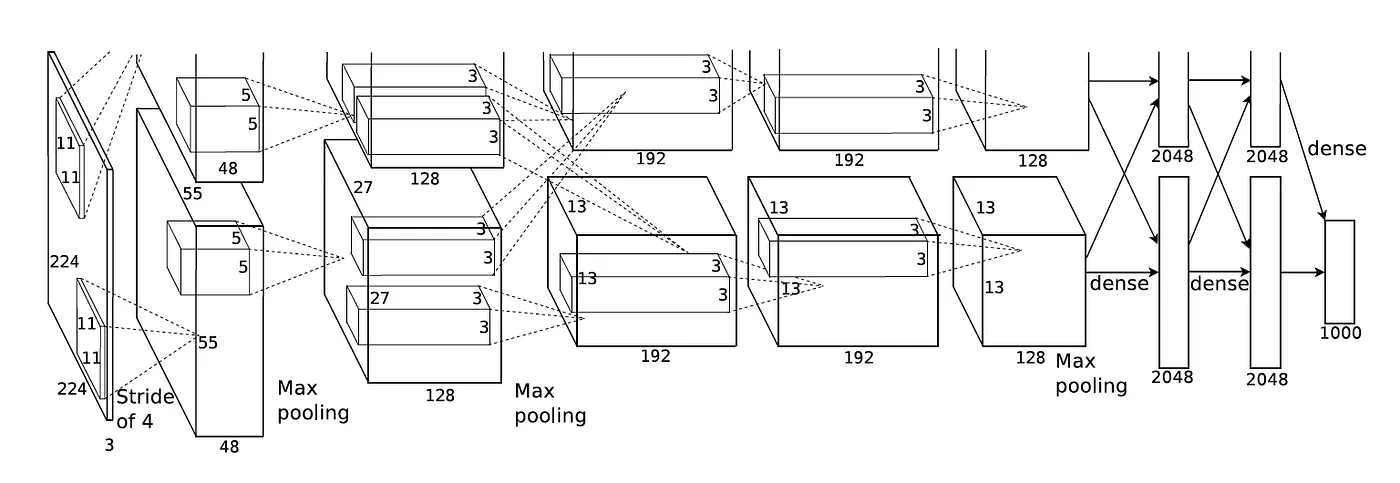

In [16]:
model = Sequential()

model.add(Conv2D(96,(11,11),strides=4,padding='same',activation='relu',input_shape=(224,224,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((3,3),strides=2))

model.add(Conv2D(256,(5,5),padding='same',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((3,3),strides=2))

model.add(Conv2D(384,(3,3),padding='same',activation='relu',strides=4))
model.add(Conv2D(384,(3,3),padding='same',activation='relu',strides=4))

model.add(Conv2D(256,(3,3),strides=4,padding='same',activation='relu'))

model.add(Flatten())

model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(4096,activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid'))



In [17]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 56, 56, 96)        11712     
                                                                 
 batch_normalization (Batch  (None, 56, 56, 96)        384       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 27, 27, 96)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 27, 27, 256)       614656    
                                                                 
 batch_normalization_1 (Bat  (None, 27, 27, 256)       1024      
 chNormalization)                                                
                                                        

In [19]:
history = model.fit(x_train,y_train, epochs=10, validation_data=(x_val,y_val))

Epoch 1/10
163/163 [==============================] - 21s 32ms/step - loss: 0.2267 - accuracy: 0.9103 - val_loss: 5.2846 - val_accuracy: 0.5000
Epoch 2/10
163/163 [==============================] - 5s 28ms/step - loss: 0.1480 - accuracy: 0.9513 - val_loss: 0.2033 - val_accuracy: 0.9375
Epoch 3/10
163/163 [==============================] - 5s 28ms/step - loss: 0.1026 - accuracy: 0.9651 - val_loss: 0.8647 - val_accuracy: 0.8125
Epoch 4/10
163/163 [==============================] - 5s 29ms/step - loss: 0.0976 - accuracy: 0.9666 - val_loss: 1.1725 - val_accuracy: 0.5625
Epoch 5/10
163/163 [==============================] - 5s 28ms/step - loss: 0.0761 - accuracy: 0.9703 - val_loss: 0.2529 - val_accuracy: 0.9375
Epoch 6/10
163/163 [==============================] - 4s 27ms/step - loss: 0.0687 - accuracy: 0.9760 - val_loss: 1.4741 - val_accuracy: 0.6875
Epoch 7/10
163/163 [==============================] - 4s 27ms/step - loss: 0.0864 - accuracy: 0.9747 - val_loss: 0.5163 - val_accuracy: 0.687

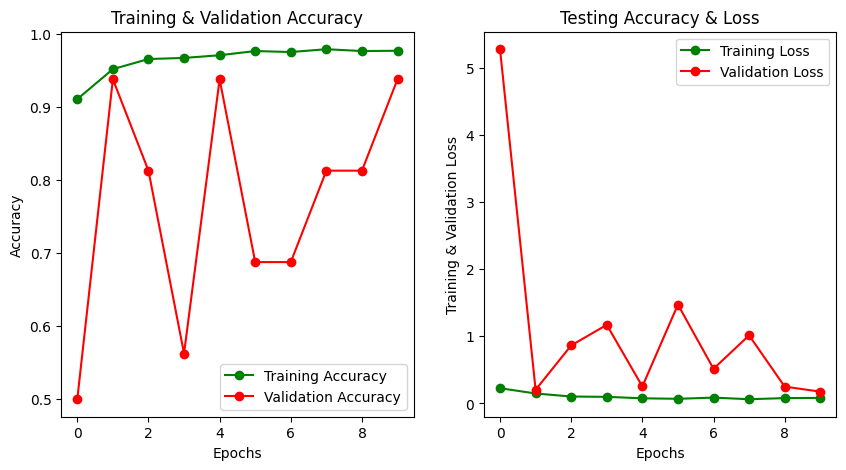

In [27]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(10,5)


ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [38]:
x_test[4]

numpy.ndarray

In [50]:
y_test[-1]

1

In [51]:
model.predict(x_test)[-1]

20/20 [==============================] - 0s 13ms/step


array([0.6647462], dtype=float32)

In [52]:
# sigmoid(0.66) = 1